In [1]:
#!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
#!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
#!pip install torch-geometric


In [2]:
#!pip install git+https://github.com/rusty1s/pyg_autoscale.git


In [15]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
import torch_geometric
from torch_sparse import SparseTensor
from torch_geometric.data import Data
from torch_geometric_autoscale import metis, permute, SubgraphLoader
import numpy as np
from matplotlib import pyplot as plt
from torch_geometric.nn import SAGEConv
from torch_geometric_autoscale.models.base import ScalableGNN
from torch_geometric_autoscale import metis, permute, SubgraphLoader
from torch.nn import ModuleList
from datetime import datetime
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import to_undirected
import json
from uuid import UUID
from base64 import b64decode as b64d
import networkx as nx
from Model import Scalable
import pickle 
import pandas as pd

In [16]:
import random
import itertools
def dataprocess(data): #удаление ребер для валидации 
        #splitting data to train and test
        train_edge_index = []
        val_edge_index = []
        indices_to_delete_for_val  = np.random.choice(list(range(len(data.edge_index[0]))), int(len(data.edge_index[0])*0.2),replace=False)
        l=0
        for i,x in enumerate(list(zip(*data.edge_index.tolist()))):
            l+=1
            if i in indices_to_delete_for_val: 
                val_edge_index.append(x)
            else: 
                train_edge_index.append(x)
                
        val_edge_index = torch.tensor(np.array(list(zip(*val_edge_index))))
        train_edge_index = torch.tensor(np.array(list(zip(*train_edge_index))), dtype = torch.long)
        
        s = set(itertools.combinations(range(len(data.x)), 2))
        
        s_of_edges = set()
        
        for pair in (data.edge_index.t().tolist()):
            s_of_edges.add(tuple(pair))
        s_of_non_edges = s - s_of_edges
        
        #append negative samples to test set
        non_edges=[]
        for pair in list(s_of_non_edges):
            non_edges.append(list(pair))
        non_edges_val=torch.tensor(random.choices(non_edges, k = len(val_edge_index[0]))).t()
        y_true_val = [1]*len(val_edge_index[0])
        val_edge_index=torch.cat((val_edge_index,non_edges_val),1)
        y_true_val += [0]*len(non_edges_val[0])
        data.edge_index = train_edge_index
        
        return data,non_edges_val,val_edge_index,y_true_val #data уже обрезанная по ребрам

In [17]:
def data_load(): #загрузить и обработать данные
   # with open('assets (16)','r', encoding="utf-8") as f:
    #    assets = json.load(f)

    with open('embeddings.json','r') as f:
        emb_map = json.load(f)

    to_uuid = lambda x: str(UUID(b64d(x, altchars=None, validate=False).hex()))
    
    #rels = []
    rels = pd.read_csv('relations.csv')
    rels=list(zip(list(rels['from']),list(rels['to'])))
    #for asset in assets:
     #   if asset['cited_articles']:
      #      source = to_uuid(asset['asset_id']['$binary'])
       #     for tt in  asset['cited_articles']:
        #        target = to_uuid(tt['$binary'])
         #       rels.append(tuple([source,target]))

    rels = [x for x in rels if x[0] in emb_map and x[1] in emb_map]
    mapping_old_to_new={}
    mapping_new_to_old = {}
    
    for id_new,id_old in enumerate(emb_map):
            mapping_old_to_new[id_old] = id_new
            mapping_new_to_old[id_new] = id_old
            
    x = []
    for id_new,id_old in enumerate(emb_map):
        x.append(emb_map[id_old]) 
        
    edges = list(map(lambda edge: [mapping_old_to_new[edge[0]], mapping_old_to_new[edge[1]]], rels)) 

    G = nx.Graph()
    G.add_edges_from(edges) #чтоб граф точно был направленным, в Graph ребра в одну сторону выписываются, хотя и считаются ненаправленными
    
    data_init = Data(x=torch.tensor(x),edge_index = torch.tensor(list(G.edges)).t() ) #тут все ребра
    return  data_init,mapping_new_to_old,mapping_old_to_new

In [18]:
def di_to_undirected(data):
    data.edge_index=to_undirected(data.edge_index)
    data.adj_t=SparseTensor(row=data.edge_index[0],col=data.edge_index[1],sparse_sizes=(len(data.x),len(data.x)))
    #SparseTensor.from_edge_index(data.edge_index)
    return data

In [19]:
data_init, mapping_new_to_old,mapping_old_to_new=data_load() #data_init - это самый изначальный граф, маппинги вершин

#data,non_edges_val,val_edge_index,y_true_val = dataprocess(data_init) #data - здесь уже без части ребер, для валидации надо
#data = di_to_undirected(data)#добавление ребер в обратную сторону
data=data_init
data_init = di_to_undirected(data_init)#добавление ребер в обратную сторону
data=di_to_undirected(data)

In [20]:
perm, ptr = metis(data.adj_t, num_parts=40, log=True)
data_train = permute(data, perm, log=True)
loader = SubgraphLoader(data_train, ptr, batch_size=1, shuffle=True)

Computing METIS partitioning with 40 parts... Done! [0.07s]
Permuting data... Done! [0.02s]
Pre-processing subgraphs... Done! [0.02s]


In [21]:
def neg_samples(edge_index,ind,num_negative_samples): #возвращает негативные примеры
    d=datetime.now()
    neg_samples=torch.Tensor(size=(len(ind),num_negative_samples+1))
    neg_samples.t()[0] = ind
    for i in ind:
        d=datetime.now()
        neig=(edge_index[1][(edge_index[0]==i).nonzero(as_tuple=True)[0]])
        neg_neigbors=ind[~ind.unsqueeze(1).eq(neig).any(1)] #difference between all indices and neighbors
        neg_neigbors=(neg_neigbors[(neg_neigbors!=i).nonzero(as_tuple=True)[0]])
        #probs = torch.zeros(max(neg_neigbors)+1)
        d=datetime.now()
        #probs[neg_neigbors]=1
        d = datetime.now()
        neg_samples[i][1:]=torch.tensor(np.random.choice(neg_neigbors,num_negative_samples))
        
    
    return neg_samples

def edge_index(batch,size): #выбираются ребра только для батча и только для вершин внутри батча
    adj=batch.adj_t
    t=(adj.to_torch_sparse_coo_tensor()).coalesce()
    ind = torch.tensor(range(size))
    edge_index = t.indices()
    first=((edge_index[0]<len(ind)).nonzero(as_tuple=True)[0])
    second=((edge_index[1]<len(ind)).nonzero(as_tuple=True)[0])
    new_indices=(torch.tensor(np.intersect1d(first,second)))
    edge_index1 =  edge_index[0][new_indices]
    edge_index2 = edge_index[1][new_indices]
    return (torch.stack([edge_index1, edge_index2], dim=0)),ind

In [22]:
def train(model,loader,num_negative_smples):
    total_loss = 0
    model.train()
    for batch,*args in loader:
        optimizer.zero_grad()
        out = model(batch.x[:args[0]], batch.adj_t,*args)
        e_index,ind=edge_index(batch,args[0])
        pos = e_index.t()
        neg = neg_samples(e_index,ind,num_negative_smples)
        samples = (pos,neg)

        loss = model.loss(out, samples)
        loss.backward()
        optimizer.step() 
        total_loss+=loss
    return total_loss/len(loader)
def test(y_true,model,data,val_edge_index):
    model.eval()
    out = model(data.x, data.adj_t)

    y_pred = []
    for x in list(zip(*val_edge_index)):
        y_pred.append(float(torch.sigmoid(torch.dot(out[x[0]],out[x[1]]))))#print(torch.sigmoid(torch.dot(out[x[0]],out[x[1]])))
    
    return roc_auc_score(y_true,torch.tensor(y_pred).detach().numpy()) 
 

10 tensor(1.0558, grad_fn=<DivBackward0>)
one epoch 0:00:02.749990
11 tensor(1.0483, grad_fn=<DivBackward0>)
one epoch 0:00:02.776546
12 tensor(1.0487, grad_fn=<DivBackward0>)
one epoch 0:00:02.780576
13 tensor(1.0445, grad_fn=<DivBackward0>)
one epoch 0:00:02.784029
14 tensor(1.0437, grad_fn=<DivBackward0>)
one epoch 0:00:02.814721
15 tensor(1.0400, grad_fn=<DivBackward0>)
one epoch 0:00:02.805497
16 tensor(1.0387, grad_fn=<DivBackward0>)
one epoch 0:00:02.794397
17 tensor(1.0375, grad_fn=<DivBackward0>)
one epoch 0:00:02.802732
18 tensor(1.0353, grad_fn=<DivBackward0>)
one epoch 0:00:02.831237
19 tensor(1.0330, grad_fn=<DivBackward0>)
one epoch 0:00:02.852543
20 tensor(1.0319, grad_fn=<DivBackward0>)
one epoch 0:00:02.847101
21 tensor(1.0309, grad_fn=<DivBackward0>)
one epoch 0:00:02.882887
22 tensor(1.0295, grad_fn=<DivBackward0>)
one epoch 0:00:02.850665
23 tensor(1.0264, grad_fn=<DivBackward0>)
one epoch 0:00:02.848076
24 tensor(1.0244, grad_fn=<DivBackward0>)
one epoch 0:00:02.85

132 tensor(0.9479, grad_fn=<DivBackward0>)
one epoch 0:00:02.878730
133 tensor(0.9472, grad_fn=<DivBackward0>)
one epoch 0:00:02.914731
134 tensor(0.9467, grad_fn=<DivBackward0>)
one epoch 0:00:02.942281
135 tensor(0.9485, grad_fn=<DivBackward0>)
one epoch 0:00:02.923121
136 tensor(0.9469, grad_fn=<DivBackward0>)
one epoch 0:00:02.903321
137 tensor(0.9482, grad_fn=<DivBackward0>)
one epoch 0:00:02.896270
138 tensor(0.9459, grad_fn=<DivBackward0>)
one epoch 0:00:02.892500
139 tensor(0.9453, grad_fn=<DivBackward0>)
one epoch 0:00:02.912996
140 tensor(0.9449, grad_fn=<DivBackward0>)
one epoch 0:00:02.899082
141 tensor(0.9464, grad_fn=<DivBackward0>)
one epoch 0:00:02.881924
142 tensor(0.9438, grad_fn=<DivBackward0>)
one epoch 0:00:02.872775
143 tensor(0.9430, grad_fn=<DivBackward0>)
one epoch 0:00:02.903909
144 tensor(0.9426, grad_fn=<DivBackward0>)
one epoch 0:00:02.919999
145 tensor(0.9446, grad_fn=<DivBackward0>)
one epoch 0:00:02.903026
146 tensor(0.9422, grad_fn=<DivBackward0>)
one e

253 tensor(0.9200, grad_fn=<DivBackward0>)
one epoch 0:00:03.223125
254 tensor(0.9202, grad_fn=<DivBackward0>)
one epoch 0:00:03.216258
255 tensor(0.9172, grad_fn=<DivBackward0>)
one epoch 0:00:03.218853
256 tensor(0.9186, grad_fn=<DivBackward0>)
one epoch 0:00:03.216626
257 tensor(0.9186, grad_fn=<DivBackward0>)
one epoch 0:00:03.237727
258 tensor(0.9196, grad_fn=<DivBackward0>)
one epoch 0:00:03.268512
259 tensor(0.9177, grad_fn=<DivBackward0>)
one epoch 0:00:03.224802
260 tensor(0.9169, grad_fn=<DivBackward0>)
one epoch 0:00:03.226350
261 tensor(0.9210, grad_fn=<DivBackward0>)
one epoch 0:00:03.241924
262 tensor(0.9177, grad_fn=<DivBackward0>)
one epoch 0:00:03.225106
263 tensor(0.9184, grad_fn=<DivBackward0>)
one epoch 0:00:03.241149
264 tensor(0.9171, grad_fn=<DivBackward0>)
one epoch 0:00:03.257741
265 tensor(0.9173, grad_fn=<DivBackward0>)
one epoch 0:00:03.355628
266 tensor(0.9163, grad_fn=<DivBackward0>)
one epoch 0:00:03.268213
267 tensor(0.9172, grad_fn=<DivBackward0>)
one e

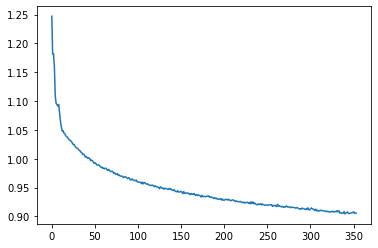

0:00:03.512339


In [31]:
d = datetime.now()
#model = Scalable(num_nodes=len(data_init.x), in_channels=len(data_init.x[0]), hidden_channels=128,out_channels=128, num_layers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,weight_decay = 1e-5)
schedular  = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
num_negative_smples=4
#losses=[]
scores=[]
for epoch in range(10,353):
        d=datetime.now()
        loss=train(model,loader,num_negative_smples)
        losses.append(float(loss))
        print(epoch,loss)
        #scheduler.step(loss)
        #score=test(y_true_val,model,data,val_edge_index)
        #scores.append(score)
        print('one epoch',datetime.now()-d)
plt.plot(losses)
plt.show()
#plt.plot(torch.tensor(scores).tolist())
#plt.show()
print(datetime.now()-d)

# Saving model

In [33]:
torch.save(model.state_dict(),'model_parameters')

# Сам инференс

### принимает параметры: 
* vertex = tuple(id, text_emb)

* neighbors = [(id, text_emb), (..)] (list of tuples)

* neighbors_of_neighbors = [(id, text_emb), (..)]

In [ ]:
#test
x=model.inference(new_vertices,old_vertices,rels)

In [ ]:
x

# plotting

In [ ]:
G = igraph.Graph.TupleList(rels, weights=False, directed=True)
igraph.summary(G)

In [ ]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import math
# plot tree
init_notebook_mode()
def plot(G, annotations=False):

    lay = G.layout_fruchterman_reingold(grid="nogrid", niter=1000)
    nr_vertices = len(G.vs)
    position = {k: lay[k] for k in range(nr_vertices)}
    Y = [lay[k][1] for k in range(nr_vertices)]
    M = max(Y)
    labels = [x['name'] for x in G.vs()]
    es = igraph.EdgeSeq(G) # sequence of edges
    E = [e.tuple for e in G.es] # list of edges

    L = len(position)
    Xn = [position[k][0] for k in range(L)]
    Yn = [2*M-position[k][1] for k in range(L)]
    Xe = []
    Ye = []
    for edge in E:
        Xe+=[position[edge[0]][0],position[edge[1]][0], None]
        Ye+=[2*M-position[edge[0]][1],2*M-position[edge[1]][1], None] 


    #Create Plotly Traces

    lines = go.Scatter(x=Xe,
                       y=Ye,
                       mode='lines',
                       line=dict(color='rgb(210,210,210)', width=1),
                       hoverinfo='none'
                       )
    dots = go.Scatter(x=Xn,
                      y=Yn,
                      mode='markers',
                      name='',
                      marker=dict(  colorbar=dict(
                                        title="Modularity"
                                    ),
                                    colorscale="Viridis",
                                    
                                  
                                    line=dict(color='rgb(50,50,50)', width=1)
                                    ),
                      
                      hoverinfo='text',
                      opacity=0.8
                      )

    # Create Text Inside the Circle via Annotations

    def make_annotations(pos, text, font_size=10, 
                         font_color='rgb(0,0,0)'):
        L=len(pos)
        if len(text)!=L:
            raise ValueError('The lists pos and text must have the same len')
        annotations = go.Annotations()
        for k in range(L):
            annotations.append(
                go.Annotation(
                    text=labels[k], # or replace labels with a different list 
                                    # for the text within the circle  
                    x=pos[k][0], y=2*M-position[k][1],
                    xref='x1', yref='y1',
                    font=dict(color=font_color, size=font_size),
                    showarrow=False)
            )
        return annotations  

    # Add Axis Specifications and Create the Layout

    axis = dict(showline=False, # hide axis line, grid, ticklabels and  title
                zeroline=False,
                showgrid=False,
                showticklabels=False,
                )
    ann = []
    if annotations:
        ann = make_annotations(position, labels)
    layout = dict(#title= 'Tree with Reingold-Tilford Layout',  
                  height=900,
                  annotations=ann,
                  font=dict(size=12),
                  showlegend=False,
                  xaxis=go.XAxis(axis),
                  yaxis=go.YAxis(axis),          
                  margin=dict(l=40, r=40, b=85, t=100),
                  hovermode='closest',
                  plot_bgcolor='rgb(248,248,248)'          
                  )

    # Plot

    data=go.Data([lines, dots])
    fig=dict(data=data, layout=layout)
    #fig['layout'].update(annotations=make_annotations(position, labels))
    iplot(fig, filename='Tree-Reingold-Tilf')
    # use py.plot instead of py.iplot if you're not using a Jupyter notebook

In [ ]:
plot(G)

# optuna todo 

In [ ]:
def objective(trial):
    
        data,mapping_new_to_old=data_loader()
        print(data)
        perm, ptr = metis(data.adj_t, num_parts=40, log=True)
        data_train = permute(data, perm, log=True)
        loader = SubgraphLoader(data_train, ptr, batch_size=10, shuffle=True)
        len(loader)

        hidden_layer = trial.suggest_categorical("hidden_layer", [32,64,128,256])
        out_layer = trial.suggest_categorical("out_layer", [64,128])
        size = trial.suggest_categorical("size of network, number of convs", [2,3])
        num_negative_samples=trial.suggest_categorical('num neg samples', [1,2,3,4,5,6,7,8,9,10])
        model = Scalable(num_nodes=len(data.x), in_channels=len(data.x[0]), hidden_channels=hidden_layer,out_channels=out_layer, num_layers=size)
        learning_rate= trial.suggest_float("lr",5e-4,1e-2)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)  

        for epoch in range(50):
            loss = train(model,loader,num_negative_smples)
        score=test(y_true_val,model,data,val_edge_index)
        
        trial.report(score,epoch)

        return score

In [ ]:
import optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective,n_trials = 20)

print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key,value))